# Project

### HOANG Caroline


The goal of this project is to declip a clipped audio based on
https://hal.science/hal-01002998/document

In [ ]:
# setup

from scipy import signal
from scipy.io import wavfile
import matplotlib.pyplot as plt
import wave
import numpy as np
import sys
import struct
import scipy.signal as ss

## Clipping

Let's have a look on the original audio.

The music audio is provided here : http://hebergement.universite-paris-saclay.fr/mkowalski/AI/data/music.wav

frate = 16000
duration of the sound : 8.7500625 sec


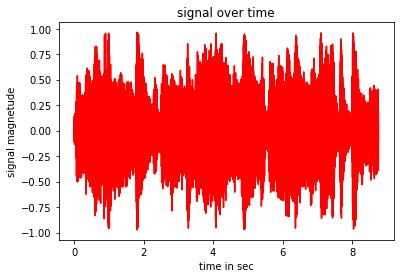

In [ ]:
# read the clean sound file
frate,sig = wavfile.read("music.wav")
print("frate =",frate)
# signal duration
duration = sig.shape[0]/frate
print("duration of the sound :",duration,"sec")
# get abscisse time corresponding to the read signal
timerange = np.linspace(0,duration , sig.shape[0])
plt.plot(timerange,sig/2**15, 'r')
plt.xlabel("time in sec")
plt.ylabel("signal magnetude")
plt.title("signal over time")
plt.show()

We define a function that similates the clipped audio in different level of clipping

In [ ]:
def clipping(sig, rate):
    new_sig = sig.copy()
    new_sig = new_sig.astype(int)
    new_sig[(abs(new_sig) >= rate * max(abs(new_sig))) & (new_sig >= 0)] = rate * max(abs(new_sig))
    new_sig[(abs(new_sig) >= rate * max(abs(new_sig))) & (new_sig < 0)] = -rate * max(abs(new_sig))
    return new_sig

We define the SNR function between the clipped and the estimated audio only on $\theta^{clip}$

In [ ]:
# y is our clipped signal
# y_estimated is our estimated signal
# M_c is the list of index of the clipped samples

def snr(y, y_estimated, M_c) :
  return 20*np.log10(np.linalg.norm(y[M_c],1)/np.linalg.norm(y[M_c]-y_estimated[M_c],1))

## Algorithm

As written in the article, we consider a hann window with 1024 of samples length

As applying an STFT and a ISTFT isn't the same length depending of our samples length and time shift we will perform both, clip it and then try to find the reliable signals and the clipped samples in index and its value.

We will take the level of clip at 0.2

In [ ]:
M = 1024 # length for the window
window_hann = ss.windows.hann(M = M, sym=True) # define our hann window

z = ss.stft(sig, window=window_hann, nperseg=M, noverlap = M//2)[2]
sig = ss.istft(z, window=window_hann, nperseg=M, noverlap = M//2)[1]

# init
clipped = clipping(sig, 0.2)# clipped audio : y

reliable_signal_index = np.where(abs(clipped) < 1*max(abs(clipped))) # get index of reliable samples of the observed signal : M^{r}
reliable_signal = clipped[reliable_signal_index] # reliable samples of the observed signal : y^{r}

clipped_sample_index = np.where(abs(clipped) >= 1*max(abs(clipped))) # get index of clipped samples of the observed signal : M^{c}
clipped_sample = clipped[clipped_sample_index] # \theta^{clip}

T = len(clipped) # length observed signal : T

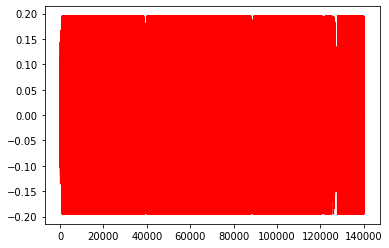

In [ ]:
plt.plot(clipped/2**15, 'r') # plot of the clipped audio

### Get $M^r$ and $M^r$ matrices

In the article we need the matrices $M^r$, $M^c$ and their respective transpose matrix. However creating the matrix itself is expensive as the dimension depends of the $N$ and $T$. That's why in Python we will consider $M^r$ (resp $M^c$) a list of index from the reliable signals (resp. from the clipped samples). To perform it transpose, we create a function called "matrix_identity_trans" that computes the transpose matrix with a vector. We create a vector of dimension $T$ with 0 and we fill values for the indexes present in the list $M^r$ (resp. $M^c$)

In [ ]:
# Compute product transpose M with a vector

# index is a list of indexes
# vector is the list of values corresponding to index
# T is the length of the signal
def matrix_identity_trans(index, vector, T) :
  res = np.array([0]*T, dtype = np.float32)
  for i in range(len(vector)):
      res[index[i]] = vector[i]
  return res

### h function

In the article, it's introduced the function $h^2$ to compute a L2 norm. But it's also used in the algorithm itself when we look at the use of the notation $[x]_+$. We implement the function $h$ itself corresponding to:
$$
R \,\to\, R_- \\
h : z \,\to\,
\begin{equation}
    \begin{cases}
      z \text{  ,  if z < 0}\\
      0 \\
    \end{cases}\,
\end{equation}
$$



In [ ]:
def h_squared(x):
  if (x < 0) :
    return x
  else:
    return 0 # We penalize when the estimated value is still greater the clipped value

### Squared hinge function
Depending of the sign of the clipped value for each k, $\theta^{clip}_k$, let $x_k$ be the estimated value :
$$
z_k =
\begin{equation}
    \begin{cases}
      \theta^{clip}_k - x_k \text{  , if  } \theta^{clip}_k  < 0\\
      x_k -\theta^{clip}_k\\
    \end{cases}\,
\end{equation}
$$
We then compute $h(z)$. The norm 2 squared associated is $\sum_z h^2(z)$.

In [ ]:
from math import sqrt
# Squared hinge squared
def square_hinge(theta_clip, x, norm= True) :
  res = theta_clip.copy()
  res = res.astype(np.float32)
  for i in range(len(theta_clip)):
    value = theta_clip[i]
    if value < 0 :
      res[i] = h_squared(value - x[i])  # z = \theta^{clip} - x
      if norm == True:
        res[i] = res[i]**2
    else :
      res[i] = h_squared(x[i] - value)  # z = x - \theta^{clip}
      if norm == True:
        res[i] = res[i]**2
  if norm == True:
    res = sqrt(sum(res))
  return res


We perform the algorithm define in the article.

$\phi^*$ corresponds to applying STFT and $\phi$ corresponds to applying ISTFT

We set our initial value:
- $\alpha_0 = \phi^*y$ where y is our clipped signal
- $z_0 = \alpha_0 \in C^N$
- $k = 1$ as the start of iteration
- $y_{estimated_0}= \phi z_0$ is the estimated signal

We perform the following computation loop until convergence :
1.  $g_1 = -\phi^*{M^r}^{T}(y_r - M^r \phi z_{k-1})$ where $y_r$ is the reliable signal
2.  $g_1 = -\phi^*{M^c}^{T}[\theta^{clip}- M^c \phi z_{k-1})]_+$
3.  $\alpha_k = S_{\lambda/\delta}(z_{k-1}- \frac{1}{\delta}(g1 + g2) )$ where $S$ is a social sparcity operator (here we will take the Lasso)
4.  $z_{k} = \alpha_{k} + \gamma(\alpha_{k} - \alpha_{k-1})$
5.  $k = k + 1$

We want to minimize : $\frac{1}{2}|| y_r - M^r \phi \alpha ||_2^2 + \frac{1}{2}[ \theta^{clip} - M^c \phi \alpha]_+^2$ (1)

We keep doing the loop as long as :
- the new value of equation (1) is still smaller than the old one due to the convexity of the problem

and respecting the conditions (s.t)
- $|M^c  \phi \alpha| \leq |\theta^{clip}|$
- $|| y_r - M^r \phi \alpha ||_2^2 \leq \epsilon $

In [ ]:
def declipping(clipped, window, y_r, theta_clip,  M_r, M_c, lb, gamma, M, N):

  ## INIT

  k = 1 # start iteration
  T = len(clipped) # length of the observed signal

  alpha_next = ss.stft(clipped, window=window, nperseg=M, noverlap = N)[2] # initiate alpha_0
  alpha_current = alpha_next

  z_next = alpha_next # z_0
  z_current= z_next.copy()

  phi_z = ss.istft(z_next, window=window, nperseg=M, noverlap = N)[1] # phi z

  phi_alpha = ss.istft(z_next, window=window, nperseg=M, noverlap = N)[1]  # phi alpha

  error = np.linalg.norm((y_r - phi_alpha[M_r])/2**15,2)**2 # s.t n°2

  optim_new = 1/2*np.linalg.norm( y_r - phi_alpha[M_r] ,2)**2 + 1/2*square_hinge(theta_clip, phi_alpha[M_c])**2 # compute equation (1)
  optim_old = 2**31-1

  while (k<=2) or (optim_new <= optim_old) : # We force 2 iterations as for the first one the old optim is the smallest and correspond to the clipped one

    # Compute g_1 and g_2
    g1 = -ss.stft(matrix_identity_trans(M_r, y_r - phi_z[M_r], T), window=window, nperseg=M, noverlap = N)[2] #g_1
    g2 = -ss.stft(matrix_identity_trans(M_c, square_hinge(theta_clip , phi_z[M_c], norm=False), T), window=window, nperseg=M, noverlap = N)[2] #g_2

    # Compute delta
    a = ss.istft(alpha_next, window=window, nperseg=M, noverlap = N)[1]
    b = ss.stft(a , window=window, nperseg=M, noverlap = N)[2]
    y = ss.istft(b, window=window, nperseg=M, noverlap = N)[1]
    delta = np.linalg.norm(y)/np.linalg.norm(a) # \delta

    # Update alpha
    alpha_current = alpha_next.copy()
    alpha_next=  z.copy() # We copy so the dtype is complex values

    for i in range(len(alpha_next[0])):
        for j in range(len(alpha_next[1])):
            scalar = 1-(lb/abs(z[i,j] - (g1[i,j] + g2[i,j])/delta))
            alpha_next[i,j] =  (z[i,j] - (g1[i,j] + g2[i,j])/delta) * max(scalar, 0)

    z_current = z_next.copy()
    z_next = alpha_next + gamma*(alpha_next - alpha_current) # z_{k}

    phi_z = ss.istft(z_next, window=window, nperseg=M, noverlap = N)[1]  # new phi z
    phi_alpha = ss.istft(alpha_next, window=window, nperseg=M, noverlap = N)[1]  # new phi alpha
    error = np.linalg.norm((y_r - phi_alpha[M_r])/2**15,2)**2 # new error

    optim_old = optim_new
    optim_new = 1/2*np.linalg.norm( y_r - phi_alpha[M_r] ,2)**2 + 1/2*square_hinge(theta_clip, phi_alpha[M_c])**2

    k += 1

    if (k % 500 == 499):
      lb = lb/10

    print("iteration : ",k, "error : ", error)
    print("snr : ",snr(clipped, phi_z, M_c))
    print("optim : ", optim_new)
    print('__________________')
  print("The value is taken is from iteration ", k-1)
  return z_current

In [ ]:
z_estimated = declipping(clipped, window_hann, reliable_signal, clipped_sample, reliable_signal_index[0], clipped_sample_index[0], 10**(-3), 0.9, M,None)

iteration :  2 error :  4.001806559423636e-05
snr :  -2.733675877189871
optim :  21484.53645375859
__________________
iteration :  3 error :  3.053429870070717e-05
snr :  2.841578223991495
optim :  16393.391146126298
__________________
iteration :  4 error :  0.00035874405557189136
snr :  2.841239674525029
optim :  192599.40473889714
__________________
The value is taken is from iteration  3


In [ ]:
y_estimated = ss.istft(z_estimated, window=window_hann, nperseg=M, noverlap = M//2)[1][:T]

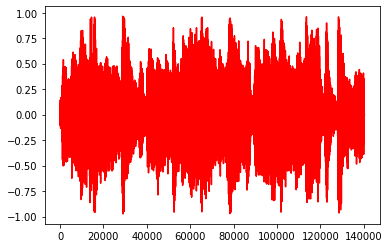

In [ ]:
plt.plot(y_estimated/2**15, 'r') # Plot of de the estimated y

Let's compare the estimated value with the real signal one before clipping it

In [ ]:
def snr_bis(y, y_estimated) :
  return 20*np.log10(np.linalg.norm(y,1)/np.linalg.norm(y-y_estimated,1))

snr_bis(y_estimated, sig)

73.38728427886963

We can see that the SNR value is high which means that our estimated signal is pretty good.

In [ ]:
from scipy.io.wavfile import write
write("declipped.wav", frate, y_estimated.astype(np.int16))